In [1]:
!pip install torch==1.11.0+cpu torchvision==0.12.0+cpu --extra-index-url https://download.pytorch.org/whl/cpu
!pip install mmcv-full==1.5.3 -f https://download.openmmlab.com/mmcv/dist/cpu/torch1.11/index.html
!pip install mmdet==2.25.0 -f https://download.openmmlab.com/mmdet/dist/cpu/torch1.11/index.html
!pip install kaleido
!pip install timm==0.5.4 natsort

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2+cpu
    Uninstalling torch-2.1.2+cpu:
      Successfully uninstalled torch-2.1.2+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.2+cpu
    Uninstalling torchvision-0.16.2+cpu:
      Successfully uninstalled torchvision-0.16.2+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.2.2 requires torch>=1.13.0, but you have torch 1.11.0+cpu which is incompatible.
stable-baselines3 2.1.0 requires torch>=1.13, but you have torch 1.11.0+cpu which is incompatible.
torchaudio 2.1.2+cpu requires torc

In [2]:
import os
import cv2
import sys
import random
import scipy as sp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=5)
sys.path.append('/kaggle/input/transfuser-e2e-scripts')

# dl imports
import torch

## CARLA dataset

In [3]:
from config import GlobalConfig
from data import CARLA_Data

root_dir = '/kaggle/input/carla-e2e-driving-data-2/Town10HD_Scenario10'
config = GlobalConfig()
config.pred_len = 6
demo_set = CARLA_Data(root=root_dir, config=config, routeKey='route7', load_raw_lidar=True)
print(f"There are {len(demo_set)} samples in Demo dataset")

100%|██████████| 1/1 [00:00<00:00, 44.71it/s]
There are 42 samples in Demo dataset


Create pytorch style dataloaders

In [4]:
from torch.utils.data import DataLoader
dataloader_demo = DataLoader(demo_set, shuffle=False, batch_size=2, num_workers=4)

In [5]:
sample_data = next(iter(dataloader_demo))
print(f"sample data is of type {type(sample_data)} and has following keys")

for k,v in sample_data.items():
    print(k, list(v.shape))
    
del sample_data

sample data is of type <class 'dict'> and has following keys
rgb [2, 3, 160, 704]
bev [2, 160, 160]
depth [2, 160, 704]
semantic [2, 160, 704]
speed [2]
x_command [2]
y_command [2]
target_point [2, 2]
target_point_image [2, 1, 256, 256]
raw_lidar [2, 10000, 3]
num_raw_lidar_points [2]
lidar [2, 2, 256, 256]
label [2, 20, 7]
ego_waypoint [2, 6, 2]


## Load pretrained model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

from model import LidarCenterNet
model = LidarCenterNet(config, device, config.backbone, image_architecture='regnety_032', 
                           lidar_architecture='regnety_032', estimate_loss = False)
model.to(device);
model.config.debug = True

model.eval();
checkpt = torch.load('/kaggle/input/carla-transfuser-regnet032/transfuser_regnet032_seed1_39.pth', map_location=device)
model.load_state_dict(checkpt)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/regnety_032_ra-7f2439f9.pth" to /root/.cache/torch/hub/checkpoints/regnety_032_ra-7f2439f9.pth


<All keys matched successfully>

## GradCAM
- CAM (Class activation maps) are localisation maps, that highlight regions of input, that were important in predicting the output.
- GradCAM can be used to visualize the important features, based upto specific layer. It uses combination of gradients and activations on each layer to calculate the Activation maps 
- Originally designed for CNN based models, numerous variants have come up, to support different models, including Transformers.
- [EigenCAM](https://arxiv.org/abs/2008.00299) is one of gradient-free methods that is used with models, involving non-differentiable steps (eg: Non Maximal suppression in Object Detection)
- e2e_cam.py is based on this [wonderful repo](https://github.com/jacobgil/pytorch-grad-cam/tree/master), that offers pytorch implementation for many CAM methods
- We'll use **EigenCAM** to visualize what different parts of network look for, before predicting final output

In [7]:
# 2 inputs are required
# - The model
# - Layers to create activation maps for
# EigenCAM calculates the activation map using activations, 
# when passing model through input data
from e2e_cam import EigenCAM

We'll use the last layers of image encoder and lidar encoder for illustration

In [8]:
target_layers = [model._model.image_encoder.features.layer1, model._model.image_encoder.features.layer2,
                 model._model.image_encoder.features.layer3, model._model.image_encoder.features.layer4,
                 model._model.lidar_encoder._model.layer1, model._model.lidar_encoder._model.layer2,
                 model._model.lidar_encoder._model.layer3, model._model.lidar_encoder._model.layer4,
                ]

# keys in input data, to which activations should be reshaped / upsampled to
shape_ref_keys = ['rgb', 'rgb', 'rgb', 'rgb', 'lidar', 'lidar', 'lidar', 'lidar']

In [9]:
with EigenCAM(model=model, target_layers=target_layers) as cam:
    for data in tqdm(dataloader_demo):
        # load data to device, according to type
        for k in ['rgb', 'depth', 'lidar', 'label', 'ego_waypoint', \
                  'target_point', 'target_point_image', 'speed']:
            data[k] = data[k].to(device, torch.float32)
        for k in ['semantic', 'bev']:
            data[k] = data[k].to(device, torch.long)

        # get model predictions
        grayscale_cam = cam(input_data=data, targets=[], key=shape_ref_keys)
        # the actual model outputs can be got here
        outputs = cam.outputs[1]
        break

  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/mmdet/models/utils/gaussian_target.py:227: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_clses = topk_inds // (height * width)
/opt/conda/lib/python3.10/site-packages/mmdet/models/utils/gaussian_target.py:229: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

In [10]:
print(f"grayscale cam is of type {type(grayscale_cam)} and length {len(grayscale_cam)}")
print(f"grayscale_cam shapes = {[x.shape for x in grayscale_cam]}")

grayscale cam is of type <class 'list'> and length 8
grayscale_cam shapes = [(2, 1, 160, 704), (2, 1, 160, 704), (2, 1, 160, 704), (2, 1, 160, 704), (2, 1, 256, 256), (2, 1, 256, 256), (2, 1, 256, 256), (2, 1, 256, 256)]


2 is batch size, 1 is number of channels (1 always), 3rd and 4th dimensions match the input (RGB image and lidar in this case)

We'll first take a lot at the RGB inputs for the first sample

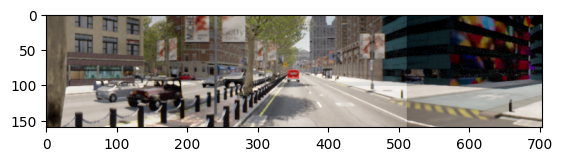

In [11]:
i = 0 # first sample in batch
rgb_image = data['rgb'][i].permute(1, 2, 0).detach().cpu().numpy()
rgb_image = rgb_image / 255.0
plt.imshow(rgb_image)

Text(0.5, 0.98, 'Image Encoder Class Activation Maps')

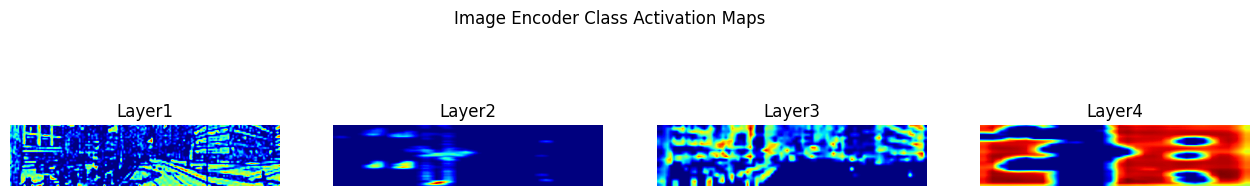

In [12]:
rgb_cam_images = [x[i,0] for x in grayscale_cam[0:4]]
fig, ax  = plt.subplots(1,4, figsize=(16,3))
for idx in range(4):
    ax[idx].imshow(rgb_cam_images[idx], cmap = 'jet');
    ax[idx].set_title(f'Layer{idx+1}')
    ax[idx].axis('off')
plt.suptitle('Image Encoder Class Activation Maps')

We will write a function to overlay the CAM output on input

In [13]:
def show_cam_on_image(img, mask, colormap = cv2.COLORMAP_JET, image_weight = 0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

Text(0.5, 0.98, 'Image Encoder Class Activation Maps')

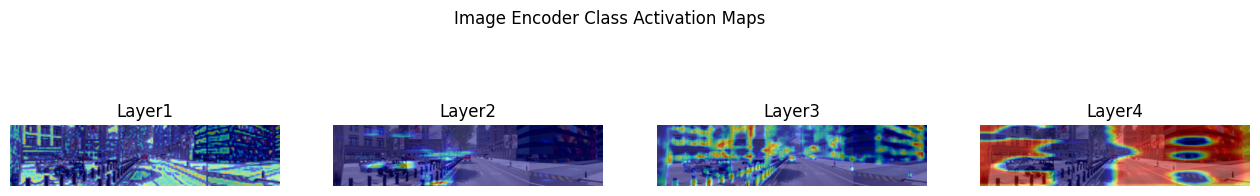

In [14]:
fig, ax  = plt.subplots(1,4, figsize=(16,3))
for idx in range(4):
    ax[idx].imshow(show_cam_on_image(rgb_image, rgb_cam_images[idx]), cmap = 'jet');
    ax[idx].set_title(f'Layer{idx+1}')
    ax[idx].axis('off')
plt.suptitle('Image Encoder Class Activation Maps')

We can do the same with lidar input

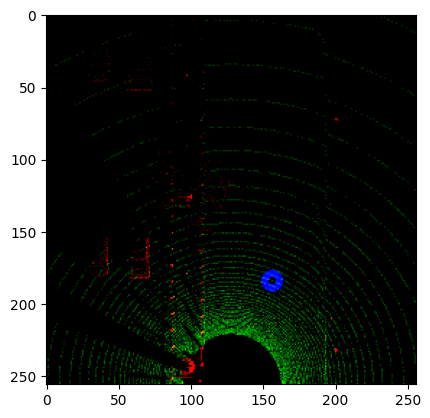

In [15]:
lidar_data = data['lidar'][i].detach().cpu().numpy().transpose(1,2,0)
plt.imshow(lidar_data)

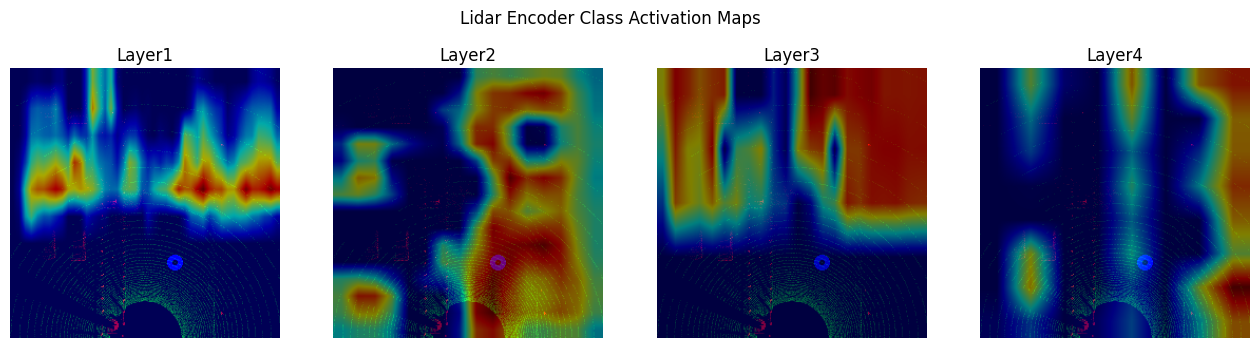

In [16]:
lidar_cam_images = [x[i,0] for x in grayscale_cam[4:]]

fig, ax  = plt.subplots(1,4, figsize=(16,4))
for idx in range(4):
    ax[idx].imshow(show_cam_on_image(lidar_data, lidar_cam_images[idx]), cmap = 'jet');
    ax[idx].set_title(f'Layer{idx+1}')
    ax[idx].axis('off')
plt.suptitle('Lidar Encoder Class Activation Maps')
plt.show()

We can visualize the model outputs

In [17]:
print(outputs.keys())

dict_keys(['pred_wp', 'pred_semantic', 'pred_depth', 'detections', 'pred_bev'])


We'll first visualize the predicted waypoints against the actual waypoints

In [18]:
pred_waypoints = outputs['pred_wp'][i]
print(pred_waypoints.shape)
print(pred_waypoints)

(6, 2)
[[-0.8539   0.05171]
 [ 0.3386   0.27257]
 [ 2.01637  0.63909]
 [ 3.79585  1.16106]
 [ 5.5706   1.81638]
 [ 7.28593  2.56465]]


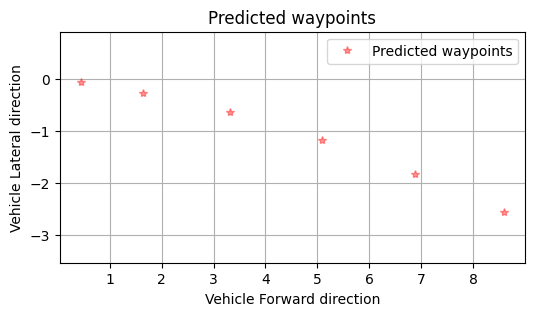

In [19]:
# the predicted waypoints are in Lidar's frame, while target waypoints
# are in vehicle frame. We need to change apply negative sign to
# y-axis, and add a constant to x-axis
pred_waypoints[:, 1] *= -1
pred_waypoints[:, 0] += 1.3

plt.figure(figsize=(6,3))
plt.plot(pred_waypoints[:,0], pred_waypoints[:,1], 'r*', label='Predicted waypoints', alpha=0.4)
plt.legend();
plt.xlabel('Vehicle Forward direction')
plt.ylabel('Vehicle Lateral direction')
plt.title('Predicted waypoints')
plt.grid(True)
plt.axis('equal');

We'll visualize the raw point cloud data, followed by bounding boxes. 

In [20]:
lidar_pc = data['raw_lidar'][i].detach().cpu().numpy()
num_points = data['num_raw_lidar_points'].detach().cpu().numpy()[i]
lidar_pc = lidar_pc[:num_points, :]

In [21]:
import plotly.graph_objects as go
from utils import plot_pc_data3d

PCD_SCENE=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False,),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.1),
)

pc_plots = plot_pc_data3d(x=lidar_pc[:,0], y=lidar_pc[:,1], z=lidar_pc[:,2])
layout = dict(template="plotly_dark", title="Raw Point cloud", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

In [22]:
pred_bev_boxes = outputs['detections'][i]

# center_x, center_y, w, h, yaw, speed, brake in bev space
print(pred_bev_boxes)

[[ 64.20869 166.99065  15.22791  32.91737   3.11985   0.40279   1.     ]
 [ 36.17534 166.92464  15.05896  30.74847   3.13331  -0.00896   1.     ]
 [ 34.29629  26.4835   17.64225  42.42176   3.12864   0.09656   1.     ]
 [ 63.09883  30.16719  18.02629  43.24938  -3.12129   0.47029   1.     ]]


This is in Lidar BEV image space (scaled by 8). We will convert to vehicle frame, Again, using following function

In [23]:
bev_to_lidar = np.array([
            [0, -(1/8.0), 32],
            [-(1/8.0), 0, 16],
            [0 , 0, 1]
])


def convert_to_3d_bboxes(boxes_2d):
    n_boxes = boxes_2d.shape[0]
    bbox_3d = np.zeros((n_boxes, 7))

    # xy position from bev pixels to metres
    homogenous_coordinates = np.hstack([boxes_2d[:, :2], np.ones((n_boxes, 1))])
    bbox_3d[:, :2] = (bev_to_lidar @ homogenous_coordinates.T).T[:, :2]
    bbox_3d[:, 3] = boxes_2d[:, 3] / 8  # length 
    bbox_3d[:, 4] = boxes_2d[:, 2] / 8  # width
    bbox_3d[:, 6] = -boxes_2d[:, 4]      # yaw

    # hardcoding z values
    bbox_3d[:, 2] = -1.25
    bbox_3d[:, 5] = 2.5
    return bbox_3d

In [24]:
pred_3d_boxes = convert_to_3d_bboxes(pred_bev_boxes)
print(pred_3d_boxes)

[[11.12617  7.97391 -1.25     4.11467  1.90349  2.5     -3.11985]
 [11.13442 11.47808 -1.25     3.84356  1.88237  2.5     -3.13331]
 [28.68956 11.71296 -1.25     5.30272  2.20528  2.5     -3.12864]
 [28.2291   8.11265 -1.25     5.40617  2.25329  2.5      3.12129]]


In [25]:
# we need to go from centre of bounding box to corners
# We have written a utility function to do the same
from utils import boxes_to_corners_3d
pred_corners_3d = boxes_to_corners_3d(pred_3d_boxes)
print(pred_corners_3d.shape)

(4, 8, 3)


We'll overlay the 3D bounding boxes on top of point cloud data

In [26]:
from utils import get_lidar3d_plots
lidar_3d_plots = get_lidar3d_plots(lidar_pc, pc_kwargs=dict(colorscale='viridis', marker_size=0.9),
                                   pred_box_corners = pred_corners_3d, 
                                   pred_box_colors = ['white'] * len(pred_corners_3d))
layout['title'] = 'Transfuser Predicted Bounding boxes'
fig = go.Figure(data=lidar_3d_plots, layout=layout)   
fig.show()

BEV map prediction

(3, 160, 160)


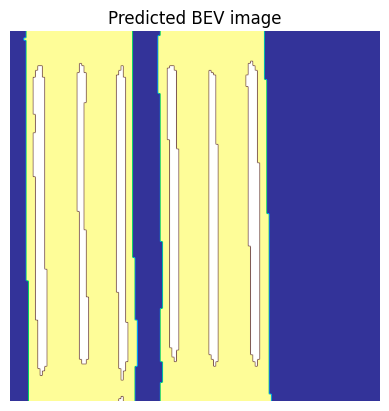

In [27]:
pred_bev = outputs['pred_bev'][i]
print(pred_bev.shape)

# there are 3 classes - unknown, driveable area, lane markings
pred_bev = np.argmax(pred_bev, axis=0)

plt.imshow(pred_bev, cmap = 'terrain');
plt.axis('off');
plt.title('Predicted BEV image');

Next up is depth prediction

Predicted Depth image shape = (160, 704)


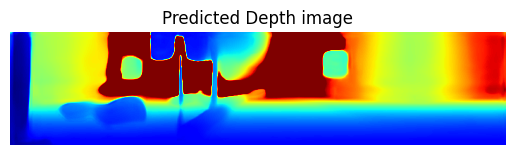

In [28]:
pred_depth_image = outputs['pred_depth'][i]
print(f"Predicted Depth image shape = {pred_depth_image.shape}")
plt.imshow(pred_depth_image, cmap = 'jet');
plt.axis('off');
plt.title('Predicted Depth image');

Lastly, we also, have the semantic segmentation output

Predicted Semantic image shape = (160, 704)


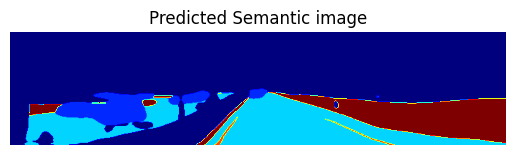

In [29]:
pred_semantic_image = outputs['pred_semantic'][i]
pred_semantic_image = np.argmax(pred_semantic_image, axis = 0)
print(f"Predicted Semantic image shape = {pred_depth_image.shape}")
plt.imshow(pred_semantic_image, cmap = 'jet');
plt.axis('off');
plt.title('Predicted Semantic image');

Now that we have seen outputs for a single sequence input, we'll see how the model responds in **Unseen scenario sequence**

## Helper functions

In [30]:
from utils import VEHICLE_TO_LIDAR_FWD, LIDAR_HEIGHT

def generate_lane_points(waypoints, lane_width = 1.0):
    # input waypoints are 2d coordinates of centerline (N,2)
    # this function generates left and right lane corners
    # by subtracting and adding half lane width. We convert
    # to 3D Lidar coordinates by placing points at ground level

    n_points = waypoints.shape[0]
    lane_points = np.zeros((n_points * 2 , 3))
    
    # vehicle to lidar frame
    lane_points[:n_points, 0] = waypoints[:,0] + VEHICLE_TO_LIDAR_FWD
    lane_points[n_points:, 0] = waypoints[:,0] + VEHICLE_TO_LIDAR_FWD
    
    # left and right lanes
    lane_points[:n_points,1] = waypoints[:,1] - (lane_width * 0.5)
    lane_points[n_points:,1] = waypoints[:,1] + (lane_width * 0.5)
    
    # fixed height
    lane_points[:,2] = -LIDAR_HEIGHT
    return lane_points

In [31]:
def get_rotated_bbox(bbox):
    x, y, w, h, yaw, _, _  =  bbox

    bbox = np.array([[h,   w, 1],
                     [h,  -w, 1],
                     [-h, -w, 1],
                     [-h,  w, 1],
                ])
    
    # The height and width of the bounding box value was changed by this factor 
    # during data collection. Fix that for future datasets and remove    
    bbox[:, :2] /= 2
    bbox[:, :2] = bbox[:, [1, 0]]

    c, s = np.cos(yaw), np.sin(yaw)
    # use y x because coordinate is changed
    r1_to_world = np.array([[c, -s, x], [s, c, y], [0, 0, 1]])
    bbox = r1_to_world @ bbox.T
    bbox = bbox.T
    bbox = np.clip(bbox, 0, 256)
    return bbox

In [32]:
def get_scatter_plot(x,y, mode='lines', marker_size=2, color=None, **kwargs):
    return go.Scatter(x=x, y=y, mode=mode, hoverinfo='skip',showlegend=False, 
                        marker = dict(size=marker_size, color=color), **kwargs)

def plot_box_corners2d(box2d, color,**kwargs):
    return [
        get_scatter_plot([box2d[0,0], box2d[1,0]], [box2d[0,1], box2d[1,1]], color=color, **kwargs),
        get_scatter_plot([box2d[1,0], box2d[2,0]], [box2d[1,1], box2d[2,1]], color=color, **kwargs),
        get_scatter_plot([box2d[2,0], box2d[3,0]], [box2d[2,1], box2d[3,1]], color=color, **kwargs),
        get_scatter_plot([box2d[3,0], box2d[0,0]], [box2d[3,1], box2d[0,1]], color=color, **kwargs),
    ]

## Visualization class

In [33]:
PCD_CAM_VIEW = dict(
            up=dict(x=0, y=0, z=1),
            eye=dict(x=-0.9, y=0, z=0.2)
    )

In [34]:
from utils import get_image2d_plots
from plotly.subplots import make_subplots

class Visualizer:
    def __init__(self, model_name, fig_width=1000, fig_height=800, pred_box_color='white', 
                 waypoints_color = 'red', bbox_2d_color = 'cyan', scene=PCD_SCENE, cam_view=PCD_CAM_VIEW):
        self.model_name = model_name

        # Create a figure, top row for point cloud data
        # bottom row for rgb image data
        self.fig = make_subplots(rows=3, cols=2,
                                 specs=[[{"type": "scatter3d", "colspan": 2}, None], 
                                        [{}, {"rowspan": 2}],
                                        [{}, None]], 
                                row_heights=[0.6, 0.2, 0.2], horizontal_spacing=0.0, vertical_spacing = 0.0)
        
        self.fig.update_layout(template="plotly_dark", scene=scene, scene_camera = cam_view,
                height = fig_height, width = fig_width, autosize=False,
                title=f"END TO END AUTONOMOUS DRIVING {self.model_name}", title_x=0.5, title_y=0.95,
                margin=dict(r=0, b=0, l=0, t=0))
        for row in range(2,4):
            for col in range(1,4):
                self.fig.update_xaxes(showticklabels=False, visible=False, row=row, col=col)
                self.fig.update_yaxes(showticklabels=False, visible=False, row=row, col=col)
        
        # set export image option
        self.fig.to_image(format="png", engine="kaleido")
        self.pred_color = pred_box_color
        self.waypoints_color = waypoints_color
        self.box2d_color = bbox_2d_color

    def clear_figure_data(self):
        self.fig.data = []
    
    def get_bbox_colors(self, bbox_corners):
        return [self.pred_color] * bbox_corners.shape[0] if bbox_corners is not None else None
        
    def plot_waypoints(self, waypoints):
        return go.Mesh3d(x=waypoints[:,0], y=waypoints[:,1], z=waypoints[:,2], 
                         opacity=0.4, color=self.waypoints_color, 
                         hoverinfo='skip',showlegend=False)

    def add_lidar_plots(self, points, waypoints, pred_corners=None):
        lidar_3d_plots = get_lidar3d_plots(points, pc_kwargs=dict(colorscale='viridis', marker_size=0.9),
                                   pred_box_corners = pred_corners, 
                                   pred_box_colors = self.get_bbox_colors(pred_corners))
        lidar_3d_plots.append(self.plot_waypoints(waypoints))
        for trace in lidar_3d_plots:
            self.fig.add_trace(trace, row=1, col=1)

    def add_image_plots(self, rgb_image, depth_image, lidar_data, pred_corners_2d):
        self.fig.add_trace(get_image2d_plots(rgb_image), row=2, col=1)
        
        # repeating depth image 3 times to get standard channel
        depth_image = np.tile(depth_image[:, :, None], (1,1,3))
        depth_image = cv2.applyColorMap(np.uint8(255 * depth_image), cv2.COLORMAP_JET)
        self.fig.add_trace(get_image2d_plots(depth_image), row=3, col=1)
        
        # BEV lidar image with bounding boxes
        self.fig.add_trace(get_image2d_plots(lidar_data), row=2, col=2)
        box_colors = [self.box2d_color] * len(pred_corners_2d)
        for i, obj_i in enumerate(pred_corners_2d):
            obj_plots = plot_box_corners2d(obj_i, color = box_colors[i])
            for plot in obj_plots:
                self.fig.add_trace(plot, row=2, col=2)
        
    def visualize_predictions(self, points, waypoints, pred_corners_3d, 
                              rgb_image, depth_image, lidar_data, pred_corners_2d):
        # clear previous data and plot lidar, image data
        self.clear_figure_data()
        self.add_lidar_plots(points=points, waypoints=waypoints, pred_corners=pred_corners_3d)
        self.add_image_plots(rgb_image, depth_image, lidar_data, pred_corners_2d)
    
    def show_figure(self):
        self.fig.show()
        
    def save_to_png(self, output_path):
        self.fig.write_image(output_path)

## Demo video

In [35]:
%matplotlib agg
dataloader_demo = DataLoader(demo_set, shuffle=False, batch_size=2, num_workers=4)
visualizer = Visualizer(model_name='TRANSFUSER')

from utils import boxes_to_corners_3d

frameIdx = 0
for data in tqdm(dataloader_demo):
    # load data to device, according to type
    for k in ['rgb', 'depth', 'lidar', 'label', 'ego_waypoint', \
              'target_point', 'target_point_image', 'speed']:
        data[k] = data[k].to(device, torch.float32)
    for k in ['semantic', 'bev']:
        data[k] = data[k].to(device, torch.long)

    # get model predictions
    _, outputs = model(data)

    # iterate through each sample in batch 
    bs = data['rgb'].shape[0]
    for i in range(bs):
        # input data
        rgb_image = data['rgb'][i].permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)
        tgt_waypoints = data['ego_waypoint'][i].detach().cpu().numpy()
        lidar_pc = data['raw_lidar'][i].detach().cpu().numpy()
        num_points = data['num_raw_lidar_points'].detach().cpu().numpy()[i]
        lidar_pc = lidar_pc[:num_points, :]

        # bev lidar image
        lidar_data = data['lidar'][i].detach().cpu().numpy().transpose(1,2,0)
        lidar_data = (lidar_data * 255).astype(np.uint8)

        # MODEL PREDICTIONS
        pred_waypoints = outputs['pred_wp'][i]
        pred_waypoints[:, 1] *= -1 
        pred_lanepoints = generate_lane_points(pred_waypoints)

        ## AUXILLARY TASK PREDICTIONS

        ## bounding boxes
        pred_boxes = outputs['detections'][i]
        pred_3d_boxes = convert_to_3d_bboxes(pred_boxes)
        pred_corners_3d = boxes_to_corners_3d(pred_3d_boxes)

        # project to bev image space
        pred_corners_2d = [get_rotated_bbox(bbox)[:, :2] for bbox in pred_boxes]

        ## depth information
        pred_depth = (outputs['pred_depth'][i] * 255).astype(np.uint8)
        pred_bev = outputs['pred_bev'][i].argmax(axis=0).astype(np.uint8)

        # plot all data
        visualizer.visualize_predictions(lidar_pc, pred_lanepoints, pred_corners_3d,
                                         rgb_image, pred_depth, lidar_data, 
                                         pred_corners_2d = pred_corners_2d)

        # save figure
        visualizer.save_to_png(f"Frame{frameIdx}.png")
        frameIdx +=1

  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/mmdet/models/utils/gaussian_target.py:227: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

/opt/conda/lib/python3.10/site-packages/mmdet/models/utils/gaussian_target.py:229: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

100%|██████████| 21/21 [03:36<00:00, 10.

In [36]:
from natsort import natsorted

def convert_images_to_video(images_dir, output_video_path, fps : int = 8):
    input_images = [x for x in natsorted(os.listdir(images_dir)) if x.endswith('png')]
    input_images = [os.path.join(images_dir, x) for x in input_images]
    
    if(len(input_images) > 0):
        sample_image = cv2.imread(input_images[0])
        height, width, _ = sample_image.shape
        
        # handles for input output videos
        output_handle = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))
    
        # create progress bar
        num_frames = int(len(input_images))
        pbar = tqdm(total = num_frames, position=0, leave=True)

        for i in tqdm(range(num_frames), position=0, leave=True):
            frame = cv2.imread(input_images[i])
            output_handle.write(frame)
            pbar.update(1)

        # release the output video handler
        output_handle.release()
                
    else:
        pass

In [37]:
FPS = 6
convert_images_to_video('./', f'scenario1_route0_{model.pred_len}pts_{FPS}fps.mp4', fps=FPS)

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████| 42/42 [00:00<00:00, 48.97it/s]
